In [ ]:
# Block 1: Initial Setup, Imports, and Google Drive Mounting

import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import glob

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths for your project files on Google Drive
# IMPORTANT: Ensure 'AGRI AI' exactly matches the folder name in your Google Drive
DRIVE_BASE_PATH = '/content/drive/MyDrive/AGRI AI'
ZIP_FILE_PATH = os.path.join(DRIVE_BASE_PATH, 'Plantdisease_dataset.zip')
EXTRACT_PATH = '/content/plant_disease_data' # Temporary extraction directory in Colab

# Create extraction directory if it doesn't exist
os.makedirs(EXTRACT_PATH, exist_ok=True)

print(f"\n--- Initial Setup Complete ---")
print(f"Drive base path set to: {DRIVE_BASE_PATH}")
print(f"Data will be extracted to: {EXTRACT_PATH}")

TensorFlow Version: 2.19.0
Num GPUs Available:  1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Initial Setup Complete ---
Drive base path set to: /content/drive/MyDrive/AGRI AI
Data will be extracted to: /content/plant_disease_data


In [ ]:
# Block 2: Data Extraction, Path Correction, and Data Generators

print(f"\n--- Unzipping Dataset ---")
try:
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Dataset unzipped successfully!")
except FileNotFoundError as e:
    print(f"ERROR: Zip file not found at {ZIP_FILE_PATH}. Please ensure the path is correct.")
    exit()

# Handle common unzip error where data is in a subfolder
extracted_contents = os.listdir(EXTRACT_PATH)
if len(extracted_contents) == 1 and os.path.isdir(os.path.join(EXTRACT_PATH, extracted_contents[0])):
    EXTRACT_PATH = os.path.join(EXTRACT_PATH, extracted_contents[0])
    print(f"Corrected EXTRACT_PATH to: {EXTRACT_PATH}")

# --- Data Preprocessing and Augmentation (Real-World Ready) ---
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Aggressive data augmentation to simulate diverse real-world conditions
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # More aggressive rotation
    width_shift_range=0.2,   # More horizontal shifting
    height_shift_range=0.2,  # More vertical shifting
    shear_range=0.2,
    zoom_range=0.3,          # More aggressive zooming
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Manually define class names, excluding 'Background_without_leaves'
dataset_class_names = sorted(os.listdir(EXTRACT_PATH))
if 'Background_without_leaves' in dataset_class_names:
    print("\n'Background_without_leaves' class detected. It will be excluded from training to improve real-world performance.")
    dataset_class_names.remove('Background_without_leaves')
NUM_CLASSES = len(dataset_class_names)

train_generator = train_datagen.flow_from_directory(
    EXTRACT_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42,
    classes=dataset_class_names
)

validation_generator = train_datagen.flow_from_directory(
    EXTRACT_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42,
    classes=dataset_class_names
)

print(f"\nTraining on {train_generator.samples} samples from {NUM_CLASSES} classes.")
print(f"Validating on {validation_generator.samples} samples.")


--- Unzipping Dataset ---
Dataset unzipped successfully!
Corrected EXTRACT_PATH to: /content/plant_disease_data/Plant_leave_diseases_dataset_without_augmentation

'Background_without_leaves' class detected. It will be excluded from training to improve real-world performance.
Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.

Training on 43456 samples from 38 classes.
Validating on 10849 samples.


In [ ]:
# Block 3: ResNet Model Architecture from Scratch

def residual_block(x, filters, stride=1, conv_shortcut=False):
    """
    A residual block for ResNet.
    """
    shortcut = x
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    if conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet_from_scratch(input_shape, num_classes):
    """
    Builds a simplified ResNet-like model from scratch.
    """
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=512)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    return model

model = build_resnet_from_scratch(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]  

 Total params: 11,473,062 (43.77 MB)

 Trainable params: 11,463,462 (43.73 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
# --- Block 4: Model Compilation ---
model = build_resnet_from_scratch(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 32, 32,    │          0 │ add_8[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_19[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_24[0][0] 

 Total params: 11,473,062 (43.77 MB)

 Trainable params: 11,463,462 (43.73 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
# --- Block 5: Checkpointing and Resuming Logic ---
CHECKPOINT_DIR = os.path.join(DRIVE_BASE_PATH, 'model_checkpoints_scratch_v2')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
checkpoint_filepath = os.path.join(CHECKPOINT_DIR, 'agri_ai_scratch_v2_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras')

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1
)

def get_latest_checkpoint(checkpoint_dir):
    checkpoints = glob.glob(os.path.join(checkpoint_dir, '*.keras'))
    if not checkpoints:
        return None, 0
    checkpoints.sort(key=os.path.getmtime)
    latest_checkpoint = checkpoints[-1]
    try:
        start_epoch = int(os.path.basename(latest_checkpoint).split('_')[5])
    except (IndexError, ValueError):
        start_epoch = 0
    print(f"Found latest checkpoint: {latest_checkpoint}, resuming from epoch {start_epoch + 1}")
    return latest_checkpoint, start_epoch + 1

latest_ckpt, initial_epoch = get_latest_checkpoint(CHECKPOINT_DIR)

if latest_ckpt:
    print(f"Loading model from checkpoint: {latest_ckpt}")
    model = load_model(latest_ckpt, custom_objects={'residual_block': residual_block, 'build_resnet_from_scratch': build_resnet_from_scratch})
    print("Model loaded successfully. Resuming training...")
else:
    print("No existing checkpoints found. Starting training from scratch.")
    model = build_resnet_from_scratch(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    initial_epoch = 0

Found latest checkpoint: /content/drive/MyDrive/AGRI AI/model_checkpoints_scratch_v2/agri_ai_scratch_v2_epoch_92_val_acc_0.9965.keras, resuming from epoch 93
Loading model from checkpoint: /content/drive/MyDrive/AGRI AI/model_checkpoints_scratch_v2/agri_ai_scratch_v2_epoch_92_val_acc_0.9965.keras
Model loaded successfully. Resuming training...


In [ ]:
# --- Block 6: Callbacks and Training Pipeline ---
LOG_DIR = os.path.join(DRIVE_BASE_PATH, 'tensorboard_logs_scratch_v2', datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1, profile_batch=0)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=0.000001, verbose=1)

callbacks = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback, tensorboard_callback]

EPOCHS = 150
print("\n" + "="*50)
print("  Agri AI Real-World-Ready (Scratch) Training Started!  ")
print("="*50)

model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    initial_epoch=initial_epoch,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("\nTraining Finished!")
final_model_path = os.path.join(DRIVE_BASE_PATH, 'final_agri_ai_scratch_v2_model.keras')
model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")


  Agri AI Real-World-Ready (Scratch) Training Started!  
Epoch 92/150
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9973 - loss: 0.0078
Epoch 92: val_accuracy improved from -inf to 0.99650, saving model to /content/drive/MyDrive/AGRI AI/model_checkpoints_scratch_v2/agri_ai_scratch_v2_epoch_92_val_acc_0.9965.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 324s 224ms/step - accuracy: 0.9973 - loss: 0.0078 - val_accuracy: 0.9965 - val_loss: 0.0169 - learning_rate: 1.0000e-06
Epoch 93/150
 212/1358 ━━━━━━━━━━━━━━━━━━━━ 3:22 177ms/step - accuracy: 0.9954 - loss: 0.0106

KeyboardInterrupt: 

In [ ]:
# Final Evaluation of the Correct, Final Model (Corrected Code)

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load custom layer definitions
def residual_block(x, filters, stride=1, conv_shortcut=False):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if conv_shortcut:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_resnet_from_scratch(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=512)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    return model

# Mount Google Drive (if in a fresh session)
from google.colab import drive
drive.mount('/content/drive')

# Define paths and parameters
DRIVE_BASE_PATH = '/content/drive/MyDrive/AGRI AI'
FINAL_MODEL_PATH = os.path.join(DRIVE_BASE_PATH, 'final_agri_ai_scratch_v2_model.keras')
EXTRACT_PATH = '/content/plant_disease_data/Plant_leave_diseases_dataset_without_augmentation'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Load the FINAL model from its saved path
try:
    model = load_model(FINAL_MODEL_PATH, custom_objects={'residual_block': residual_block})
    print("Final trained model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# === CORRECTED LOGIC ===
# Get the class names from the extracted folder structure, and exclude 'Background_without_leaves'
class_names = sorted(os.listdir(EXTRACT_PATH))
if 'Background_without_leaves' in class_names:
    class_names.remove('Background_without_leaves')
print(f"Loaded {len(class_names)} class names: {class_names[:5]}...")

# Now, we use this exact list of class names to set up the validation generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = val_datagen.flow_from_directory(
    EXTRACT_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=class_names # === IMPORTANT CORRECTION: Pass the class list ===
)

print(f"\nEvaluation setup complete. Ready to evaluate on {validation_generator.samples} validation samples.")

# Get predictions and true labels
print("\n--- Generating Predictions and Metrics ---")
y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = validation_generator.classes

# Print the Classification Report
target_names = list(validation_generator.class_indices.keys())
print("\n--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final trained model loaded successfully!
Loaded 38 class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...
Found 10849 images belonging to 38 classes.

Evaluation setup complete. Ready to evaluate on 10849 validation samples.

--- Generating Predictions and Metrics ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step

--- Classification Report ---
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.99      1.00       126
                            Apple___Black_rot       0.95      1.00      0.98       124
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                              Apple___healthy       0.98      0.98      0.98       329
                          Blueberry___healthy       1.00      0.93      0.96       300
                      Cherry___Powdery_mildew       1.00      1.00      1.00       210
                             Cherry___healthy       0.99      0.99      0.99       170
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.97      0.89       102
                           Corn___Common_rust       0.99      1.00      0.99       238
                  Corn___Northern_Leaf_Blight       0.9


--- Confusion Matrix ---


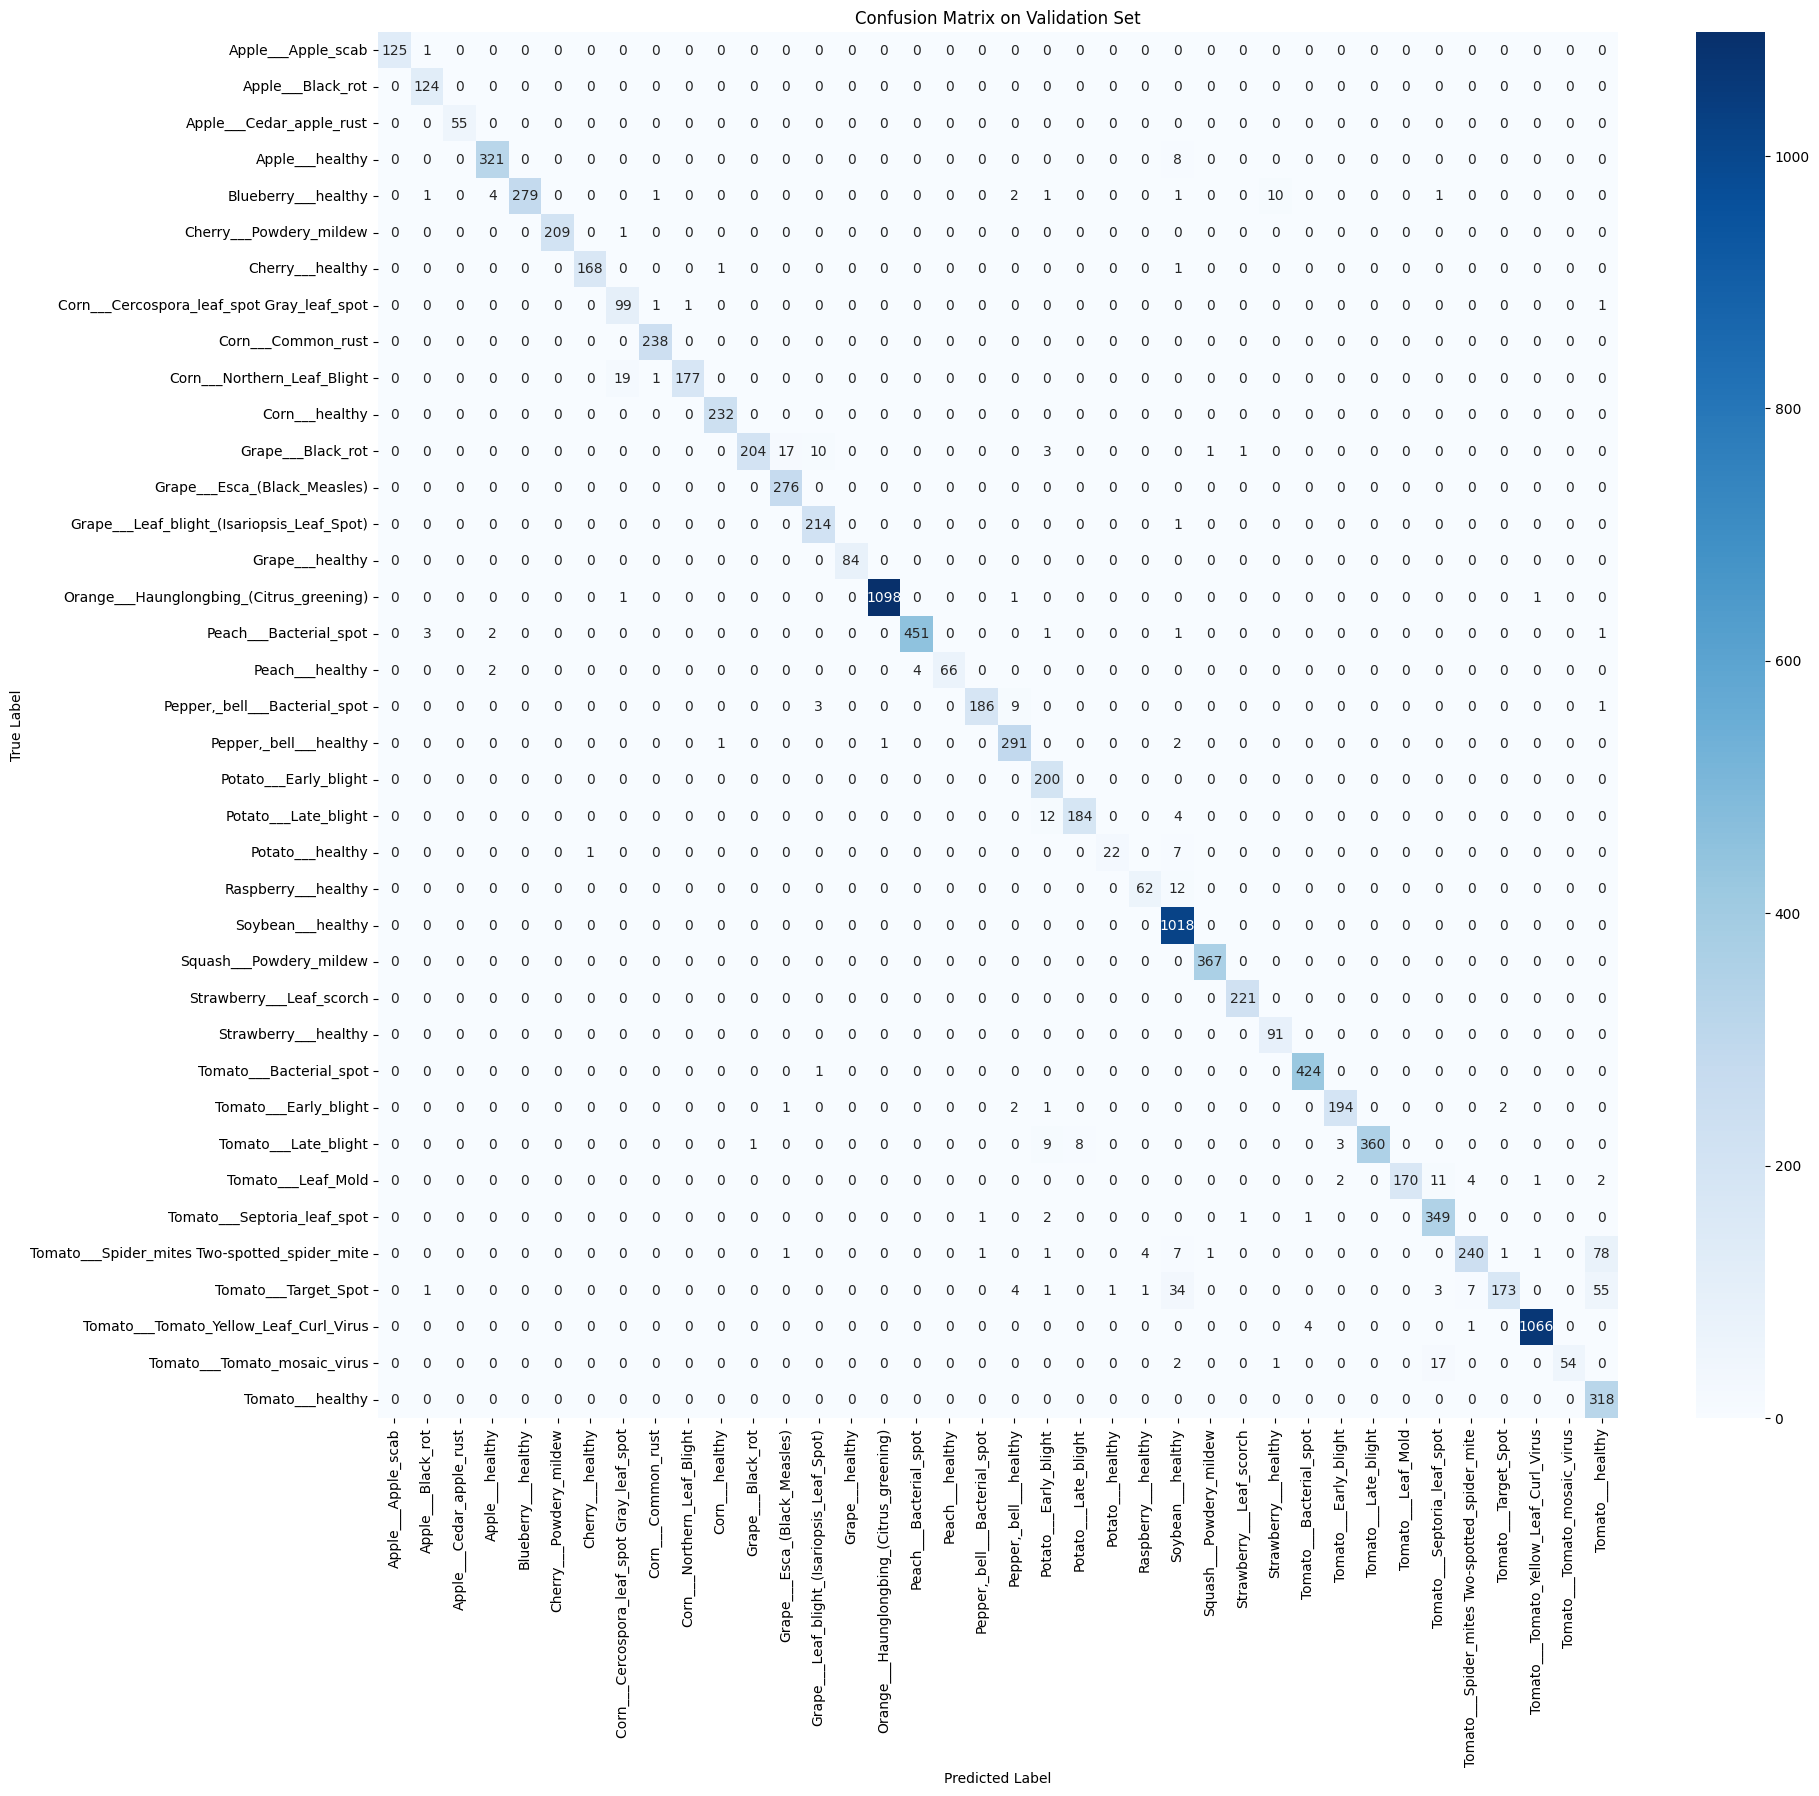


Evaluation completed!


In [ ]:
# Plot the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nEvaluation completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final trained model loaded successfully!
Loaded 38 class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

--- Prediction for tomato healthy.jpeg ---
Predicted Class: Tomato___Late_blight
Confidence: 72.82%
Top Predictions:
  - Tomato___Late_blight: 72.82%


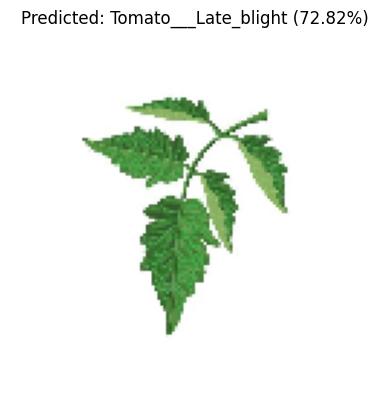

In [ ]:
# Final Step: Test the Robust Model with a New Image

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

# Load custom layer definitions (necessary for loading the custom ResNet model)
def residual_block(x, filters, stride=1, conv_shortcut=False):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if conv_shortcut:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_resnet_from_scratch(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2, conv_shortcut=True)
    x = residual_block(x, filters=512)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    return model


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths and parameters
DRIVE_BASE_PATH = '/content/drive/MyDrive/AGRI AI'
FINAL_MODEL_PATH = os.path.join(DRIVE_BASE_PATH, 'final_agri_ai_scratch_v2_model.keras')
EXTRACT_PATH = '/content/plant_disease_data/Plant_leave_diseases_dataset_without_augmentation'
IMAGE_SIZE = (128, 128)
NUM_CLASSES = 38

# Load the model
try:
    model = load_model(FINAL_MODEL_PATH, custom_objects={'residual_block': residual_block})
    print("Final trained model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Get the class names from your dataset structure (excluding the background class)
class_names = sorted(os.listdir(EXTRACT_PATH))
if 'Background_without_leaves' in class_names:
    class_names.remove('Background_without_leaves')
print(f"Loaded {len(class_names)} class names: {class_names[:5]}...")

def predict_plant_disease(image_path, model, class_names, image_size=(128, 128)):
    """
    Loads an image, preprocesses it, and makes a prediction.
    """
    try:
        img = image.load_img(image_path, target_size=image_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        predictions = model.predict(img_array)
        probabilities = predictions[0]
        predicted_index = np.argmax(probabilities)
        predicted_class_name = class_names[predicted_index]
        confidence_score = probabilities[predicted_index] * 100

        print(f"\n--- Prediction for {os.path.basename(image_path)} ---")

        if confidence_score < 50.0:
            print("Action Required: The model's confidence is too low to make a reliable prediction.")
            print("The image may not be a leaf from a plant the model was trained on.")
        else:
            print(f"Predicted Class: {predicted_class_name}")
            print(f"Confidence: {confidence_score:.2f}%")
            print("Top Predictions:")
            top_n = 1
            top_indices = np.argsort(probabilities)[::-1][:top_n]
            for i in top_indices:
                print(f"  - {class_names[i]}: {probabilities[i]*100:.2f}%")

        plt.imshow(img)
        plot_title = f"Predicted: {predicted_class_name} ({confidence_score:.2f}%)" if confidence_score >= 50.0 else "Unreliable Prediction"
        plt.title(plot_title)
        plt.axis('off')
        plt.show()

        return predicted_class_name, confidence_score, probabilities

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None, None, None
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None, None, None


new_image_path = '/content/tomato healthy.jpeg' # CHANGE THIS PATH to your uploaded file

if os.path.exists(new_image_path):
    predicted_class, confidence, probabilities = predict_plant_disease(
        new_image_path, model, class_names, image_size=IMAGE_SIZE
    )
else:
    print(f"Image not found at {new_image_path}. Please upload a test image and try again.")